## **Mapeando datos**

### **1. Importamos las respectivas librerías**

In [1]:
import pandas as pd
import zipfile
from pathlib import Path
import shutil
import folium
import sqlite3
import matplotlib.colors as mcolors
import streamlit as st
from streamlit_folium import st_folium
import matplotlib.pyplot as plt

### **2. Descomprimimos los archivos correspondientes**

➡️ Creamos una variable path que nos ayude a indentificar donde estan todos los archivos zip.

🗒️ **Observaciones:** Vamos a utilizar la metodologia del staging, que para este caso será mantener los archivos crudos en la carpeta raw y, cuando ya estén transformados, los vamos a localizar en la carpeta silver. Esta informacion proviene deL DANE 🔗 https://microdatos.dane.gov.co/index.php/catalog/697/get-microdata

In [2]:
raw_path = '/home/npalaciosv/Catedra/Geoanalitycs/src/Data/Raw/'
silver_path = '/home/npalaciosv/Catedra/Geoanalitycs/src/Data/Silver/'

➡️ Para poder recorrer los archivos vamos a utilizar la libreria *"Path"*, la cual es más sensilla de usar que la libreria *"Os"*.

In [3]:
# Creamos un objetio Path con la direccion de los archivos crudos
data_files = Path(raw_path)

# Recorremos cada uno de los archivos usando la funcion rglob('*')
for file in data_files.rglob('*'):

    # Para evitar que los espacios y el guion bajo afecten algun comando, los eliminamos del nombre del archivo
    new_name = file.name.replace(" ","").replace("_","")

    # Ajustamos el path completo ahora con el nuevo nombre
    new_path = file.with_name(new_name)

    # Con esta funcion renombramos el archivo.
    file.rename(new_path)

    # Iniciamos el proceso de extraccion de cada archivo
    with zipfile.ZipFile(f'{raw_path+file.name}','r') as extraction:

        # La informacion sera extraida la carpeta Silver
        extraction.extractall(silver_path)

➡️ Como podemos ver, los archivos vienen en varios formatos, sin embargo, a nosotros solo nos interesa aquellos con formato .csv, así que procedemos a eliminar el resto de archivos.

🗒️ **Observaciones:** Al parecer, algunos archivos se descomprimen directamente y otros quedan venian dentro de una carpeta, así que nos toca primera trabajar con los archivos que se descomprimieron directamente y luego con los que quedaron dentro de una carpeta

In [4]:
# Creamos un objetio Path con la direccion de los archivos descomprimidos
silver_files = Path(silver_path)

# Recorremos cada uno de los archivos para verificar su extension. Usamos la funcion iterdir()
for file in silver_files.iterdir():

    # Verificamos si es un archivo (ya que puede ser una carpeta) y no termina en '.csv'
    if file.is_file() and file.suffix != '.csv':

        # Eliminamos el archivo y lo notificamos
        file.unlink()

In [5]:
# Recorremos cada uno de los archivos para verificar que sea una carpeta
for file in silver_files.iterdir():

    # Si archivo es realmente un archivo, sin importar el formato, no pasará nada, pero si es una carpeta movera el archivo fuera de esta
    if file.is_file():
        pass
    else:
        # Nos movemos un nivel mas en el path, es decir, entramos en la carpeta
        subfolder = silver_files.joinpath(file.name)

        #Recorremos la carpeta
        for subfile in subfolder.glob('*'):

            # Buscamos los archivos .csv y los movemos a un nivel anterior en el path, es decir, los ponemos al nivel de los anteriores
            if subfile.suffix == '.csv':
                subfile.replace(silver_path+"/"+subfile.name)
                print(f'Archivo: {subfile.name} movido exitosamente')

        # Eliminamos la carpeta una vez el archivo se ha movido al nivel anterior
        shutil.rmtree(subfolder)

Archivo: 2021(II Semestre).csv movido exitosamente
Archivo: SIPSA_A_Isem2022.csv movido exitosamente
Archivo: SIPSA_A Isem2024.csv movido exitosamente
Archivo: SIPSA_A_IIsem2023.csv movido exitosamente
Archivo: SIPSA_A_Isem2023.csv movido exitosamente


### **3. Unificamos la informacion que necesitamos**

⚠️ **Alertas:** Revisando la informacion previamente, nos dimos cuenta que no todos los archivos traen las columnas con el mismo nombre, por lo tanto nos toca hacer una homologacion de nombre.

In [6]:
# Creamos un diccionario que servira para homologar los nombres correspondientes

columnas_ajustadas = {
    'Fuente':'Mayorista',
    'FechaEncuesta':'Fecha',
    'Fecha':'Fecha',
    'Cod. Depto Proc.':'Codigo_departamento',
    'Cod. Municipio Proc.':'Codigo_municipio',
    'Departamento Proc.':'Departamento',
    'Municipio Proc.':'Municipio',
    'Grupo':'Grupo',
    'Ali':'Alimento',
    'Cant Kg':'Cant_Kg',
    'Código Departamento':'Codigo_departamento',
    ' Código Municipio ':'Codigo_municipio',
    'Alimento':'Alimento',
    'Cuidad, Mercado Mayorista':'Mayorista',
    'Origen':'Origen',
    'Unnamed: 9':'Unnamed: 9',
    'Unnamed: 10':'Unnamed: 10',
    'Codigo CPC':'Codigo CPC'
}

➡️ Unimos todos los archivos en un dataframe unico que nos permitirá consolidar la informacion...😨 Anticipo que va a ser bien pesado

In [7]:
# Creamos un dataframe vacio que nos permitira consolidar todos los archivos
df = pd.DataFrame()

# Recorremos archivo por archivo para irlos consolidando
for file in silver_files.iterdir():

    # Leemos cada archivo. Usamos 'unicode_escape' ya que es el formato que nos permite leer los archivos sin ningun error
    df_temp = pd.read_csv(file, encoding='unicode_escape', sep=";")

    # Creamos una columna que nos permitira rastear de que archivo esta saliendo la informacion
    df_temp['Origen'] = file.name

    # Cambiamos el nombre de las columnas de acuerdo con el diccionario que definimos previamente
    for column in df_temp.columns:
        df_temp.rename(columns={column: columnas_ajustadas[column]}, inplace=True)

    # Concatenamos los dataframes
    df =pd.concat([df,df_temp], ignore_index=True)

/tmp/ipykernel_181098/2693946809.py:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(file, encoding='unicode_escape', sep=";")


➡️ Algunas columnas no traen datos, por tal motivo las vamos a eliminar

In [8]:
df = df.drop(['Unnamed: 9','Unnamed: 10','Codigo CPC'],axis=1)

⚠️ **Alertas:** Al ser informacion de un caso de estudio real, era probable que nos encontrarmos con ciertos datos que representaban problemas de calidad de informacion. Los que se identificaron previamente son los siguiente:

1. Existe "Cali, Santa Helena" y "Cali, Santa Elena". *Solucion:* Homologar el nombre a "Cali, Santa Helena".
2. El codigo del municipio trae una apostrofe "'" al principio como mecanismo para convservar el cero del inicio. *Solucion:* Eliminar el apostrofe.
3. En algunos casos, el codigo del municipio traia un espacio al inicio. *Solucion:* Quitar ese espacio usando la funcion strip.
4. El codigo del departamento trae una apostrofe "'" al principio como mecanismo para convservar el cero del inicio. *Solucion:* Eliminar el apostrofe.
5. En algunos casos, el codigo del departamento traia un espacio al inicio. *Solucion:* Quitar ese espacio usando la funcion strip.
6. La cantidad de kg no estaba en formato de numero.*Solucion:* Cambiar el formato.

In [9]:
#1
df.loc[df["Mayorista"] == "Cali, Santa Elena", "Mayorista"] = "Cali, Santa Helena"

#2 
df['Codigo_municipio'] = df['Codigo_municipio'].str.replace("'","")

#3
df['Codigo_municipio'] = df['Codigo_municipio'].str.strip()

#4
df['Codigo_departamento'] = df['Codigo_departamento'].str.replace("'","")

#5
df['Codigo_departamento'] = df['Codigo_departamento'].str.strip()

#6. error = coerce hace que la funcion no falle cuando se encuentra con valores con nan
df['Cant_Kg'] = pd.to_numeric(df['Cant_Kg'], errors='coerce')

➡️ Como el datarame construido esta tan grande, puede que su manipulacion sea tediosa, por lo tanto vamos a construir una bases de datos usando sqllite que nos permita almacenar la informacion.

⚠️ **Alertas:** Esta base de datos la vamos a construir fuera de wsl2, ya que este impide la conexion con la base.

In [10]:
# Definimos la ruta en la que vamos a almacenar la informacion.
user_path = '/mnt/d/Classes/Data visualization/Mapping data/Database/geo.db'

# Creamos un objeto sqlite3 que nos permitira conectarnos con la base de datos
conn = sqlite3.connect(user_path)

# Enviamos la informacion del dataframe al base de datos
df.to_sql('Fact', con=conn, if_exists='replace', index=False)

11764957

### **4. Iniciamos con la construccion de los mapas**

#### **4.1 Establecemos las coordenadas de los centros mayoristas**

➡️ Como en la base de datos creada no existen las coordenadas de las plazas mayoristas, estas fueron consolidadas de manera manual y estan en la carpeta Data/Static.

🗒️ **Observaciones:** Vamos a enviar toda la informacion que construyamos a la base de datos que justo creamos para aprovechar la facilidad de estructuracion de informacion que ofrece SQL

In [11]:
# Creamos la ruta donde se va a consultar la informacion de las coordenadas de los mayoristas
coordenadas_path = "/home/npalaciosv/Catedra/Geoanalitycs/src/Data/Static/Coordenadas.csv"

# Leemos la informacion dentro de un dataframe.
df_coor = pd.read_csv(coordenadas_path,sep=";",encoding='utf-8')

# Enviamos la informacion a la base de datos creada previamente
df_coor.to_sql('Coordenadas_mayoristas', con=conn, if_exists='replace', index=False)

32

➡️ Vamos a utilizar la libreria Folium para construir los mapas correspondientes.

In [12]:
# Iniciamos un objeto map de folium, centrando la vista inicial del mapa en Bogota
map = folium.Map(location=[4.922860659232988, -74.02580517889908], zoom_start=7)

# Definimos una ruta en la que va a almacenarce el mapa.
maps_path = '/home/npalaciosv/Catedra/Geoanalitycs/src/Graphs/'

➡️ Es hora de crear la primera consulta que nos va a traer la informacion exactamente como la necesitamos para crear el primer layout del mapa

In [13]:
#Creamos la sentencia sql
sentencia_sql = f'''
                SELECT 
                    f.Mayorista,
                    cm.Latitud,
                    cm.Longitud,
                    SUM(f.Cant_Kg) AS Produccion
                FROM Fact f
                LEFT JOIN Coordenadas_mayoristas cm ON cm.Mayorista = f.Mayorista
                WHERE f.Mayorista IS NOT NULL
                GROUP BY f.Mayorista,cm.Latitud,cm.Longitud
                ORDER BY Produccion DESC
                ;
                '''

# Ejcutamos la sentencia sql y almacenamos el resultado en un dataframe
df_may = pd.read_sql_query(sentencia_sql, conn)

In [14]:
# Convertimos la informacion consultada en listas sobre las que vamos a iterar para agregar elementos al mapa
lat = df_may['Latitud'].to_list()
lon = df_may['Longitud'].to_list()
may = df_may['Mayorista'].to_list()
prod = df_may['Produccion'].to_list()

# Combinamos las listas con la funcion zip para que podamos iterar con toda la informacion simultaneamente
coordenadas = list(zip(lat,lon,may,prod))

In [15]:
# Definimos el icono con el que vamos a representar a los mayoristas dentro del mapa
icon_path = '/home/npalaciosv/Catedra/Geoanalitycs/src/Icons/Mayorista.png'

# Vamos iterar sobre cada mayorista para localizarlo en el mapa
for lat,lon,may,prod in coordenadas:
    # Iniciamos el elemento marker desde Folium
    folium.Marker(
        [lat,lon],
        popup=f'{may}',
        icon=folium.CustomIcon(icon_image=icon_path,icon_size=(25,25))
    ).add_to(map)

# Guardamos el mapa generado para efectos de consulta
map.save(maps_path+"mapa.html")

#### **4.2 Establecemos las coordenadas de los municipios abastecedores**

➡️ Cargamos la informacion que aparece en el archvio Data/Static/Clasificador_geografico.csv. Este archivo contiene las coordenadas de todos los municipios de Colombia.

🗒️ **Observaciones:** Recordemos que la informacion que estamos consultando es oficial, por lo tanto tanto las bases del DANE como el clasificador geografico conservan las mismas llaves 😄

In [16]:
# Definirmos los tipos de datos específicos para las columnas
column_types = {'Código Departamento': str, 'Código Municipio': str, 'Código Centro Poblado': str}

# Creamos un diccionario que nos permitira homologar los nombres de la base de datos
column_rename_map = {
    'Código Departamento': 'Codigo_Departamento',
    'Código Municipio': 'Codigo_Municipio',
    'Código Centro Poblado': 'Codigo_Centro_Poblado'
}

# Definimos el path de donde se va a traer la informacion del clasificador geografico
geopath = '/home/npalaciosv/Catedra/Geoanalitycs/src/Data/Static/Clasificador_geografico.csv'

# Creamos un dataframe con la informacion contenida en el clasificador geografico
df_geoclas = pd.read_csv(geopath,sep=";",encoding='utf-8', dtype=column_types)

# Renombramos las columnas correspondientes
df_geoclas = df_geoclas.rename(columns=column_rename_map)

⚠️ **Alertas:** El clasificador geografico trae, para cada municipio, la coordenada de cada uno de sus barrios. Como nosotros solo necesitamos una coordenada, vamos a elegir unicamente la primera que aparezca

In [17]:
# Eliminamos las columnas innecesarias
df_geoclas = df_geoclas[['Codigo_Departamento','Codigo_Municipio','Longitud','Latitud']]

# Dejamos solo una coordenada para cada municipio
df_geoclas = df_geoclas.drop_duplicates(subset=['Codigo_Municipio'])

# Ajustamos los valors de latitud y longitud para que puedan ser interpretados como numero
df_geoclas['Latitud'] = df_geoclas['Latitud'].str.replace(",",".")
df_geoclas['Longitud'] = df_geoclas['Longitud'].str.replace(",",".")

# Enviamos la informacion a una tabla dentro de la base de datos
df_geoclas.to_sql('Clasificador_geografico', con=conn, if_exists='replace', index=False)

1122

🗒️ **Observaciones:** Para poder llenar las coordenadas vacias dentro de la tabla fact, vamos a cotejarla con las coordendas de los municipios "internacionales"

In [20]:
# Traemos la informacion de municipio, longitud y latitud de la tabla Fact
sentencia_sql = f'''
                SELECT
                    DISTINCT f.Codigo_Municipio,
                    f.Municipio,
                    cg.Latitud,
                    cg.Longitud
                FROM Fact f
                LEFT JOIN Clasificador_geografico cg ON cg.Codigo_Municipio = f.Codigo_Municipio
                    ;
                '''
# Enviamos la informacion a un dataframe
df_int = pd.read_sql_query(sentencia_sql, conn)

⚠️ **Alertas:** Como pudimos ver en la tabla Fact, algunos municipios corresponden a locaciones internacionales, por lo tanto no se señala ninguna coordenada. Manualmente hay creado un archivo con estas coordenadas para poder mapear estos puntos.

🗒️ **Observaciones:** Leemos el archivo de las coordenadas internacionales para tenerlo como fuente de comparacion y poder rellenar las coordenadas faltantes

In [21]:
# Definimos el path donde esta el archivo con las coordenadas de los puntos internacionales
coordenadas_int_path = "/home/npalaciosv/Catedra/Geoanalitycs/src/Data/Static/Coordenadas_internacionales.csv"

# Enviamos la informacion a un dataframe
df_coor_int = pd.read_csv(coordenadas_int_path,sep=";",encoding='utf-8')

# Ajustamos los valors de latitud y longitud para que puedan ser interpretados como numero
df_coor_int['Latitud'] = df_coor_int['Latitud'].astype(float)
df_coor_int['Longitud'] = df_coor_int['Longitud'].astype(float)

In [22]:
# Creamos una lista con todos los municipios "internacionales"
list_coor_int = df_coor_int['Municipio'].to_list()

In [23]:
# Esta funcion hace que cuando haya un municipio "internacional", el dataframe le asigne las coordenadas correspondientes
for mun_int in list_coor_int:
    df_int.loc[df_int['Municipio']==mun_int,'Latitud'] = df_coor_int.loc[df_coor_int['Municipio']==mun_int,'Latitud'].values
    df_int.loc[df_int['Municipio']==mun_int,'Longitud'] = df_coor_int.loc[df_coor_int['Municipio']==mun_int,'Longitud'].values

# Deja valores unicos para cada municipio internacional
df_int = df_int.dropna()

# Enviamos la informacion como una tabla a la base de datos
df_int.to_sql('Coordenadas_internacionales', con=conn, if_exists='replace', index=False)

1147

➡️ Ahora, agregamos los elementos correspondientes al mapa

In [24]:
# Definimos el path donde esta el logo que vamos a usar para identificar los municipios productores
icon_path = '/home/npalaciosv/Catedra/Geoanalitycs/src/Icons/Productor.png'

# Convertimos la informacion consultada en listas sobre las que vamos a iterar para agregar elementos al mapa
lat = df_int['Latitud'].to_list()
lon = df_int['Longitud'].to_list()
municipio = df_int['Municipio'].to_list()

# Combinamos las listas con la funcion zip para que podamos iterar con toda la informacion simultaneamente
coordenadas = list(zip(lat,lon,municipio))

# Vamos iterar sobre cada municipio para localizarlo en el mapa
for lat,lon,municipio in coordenadas:
    folium.Marker(
        [lat,lon],
        popup=f'{municipio}',
        icon=folium.CustomIcon(icon_image=icon_path,icon_size=(15,15))
    ).add_to(map)

# Guardamos el mapa generado para efectos de consulta
map.save(maps_path+"mapa.html")

#### **4.3 Coloreamos cada departamento de acuerdo a su capacidad productora**

➡️ Para poder tener una delimitacion completa de cada departamento de colombia es necesario consultar la informacion geojson que la representa. En este caso, vamos utilizar esta informacion de referencia 🔗 https://gist.github.com/john-guerra/43c7656821069d00dcbc.

Este archivo esta en Data/Static/colombia.geo.json.

In [25]:
# Definimos el path que nos lleva al archivo geojson
geopath = '/home/npalaciosv/Catedra/Geoanalitycs/src/Data/Static/colombia.geo.json'

# Agregamos el layer con la division departamental al mapa
folium.GeoJson(geopath,
               style_function= lambda feature : {
                        'color': 'black',
                        'weight': 2,
                        'dashArray': '5, 5',
                        'fillOpacity': 0.5,
                        }
               ).add_to(map)

# Guardamos el mapa
map.save(maps_path+"mapa.html")

In [26]:
# Creamos una consulta sql que nos va traer la informacion de productividad por departamento
sentencia_sql = f'''
                SELECT
                    f.Codigo_departamento AS DPTO,
                    SUM(f.Cant_Kg) AS Produccion
                FROM Fact f
                WHERE f.Codigo_departamento != 'n.a.'
                GROUP BY f.Codigo_departamento
                ORDER BY Produccion DESC
                ;
                '''

# Guardamos la informacion en un dataframe
df_temp = pd.read_sql_query(sentencia_sql, conn)

In [27]:
# Convertimos el DataFrame a un diccionario
temp_dict = df_temp.to_dict(orient='records')

In [28]:
# Función para asignar color basado en la producción
def asignar_color(feature):

    # Calcular el mínimo y máximo de las producciones
    producciones = [item['Produccion'] for item in temp_dict]
    produccion_minima = min(producciones)
    produccion_maxima = max(producciones)*0.4 # Este valor esta castigado para mejorar un poco la colorimetria del mapa

    # Definir colores en la escala
    color_minimo = 'red'
    color_medio = 'orange'
    color_maximo = 'green'

    # Extramos el codigo del departamento que esta contenido en el archivo geojson
    codigo_departamento = feature['properties'].get('DPTO')

    # Obtenemos la producción de la consulta que guardamos en df_temp o 0 si no está definido
    produccion = next((item['Produccion'] for item in temp_dict if item['DPTO'] == codigo_departamento), 0)

    # Normalizamos la producción entre 0 y 1
    norm = mcolors.Normalize(vmin=produccion_minima, vmax=produccion_maxima)

    # Crear una interpolación lineal de colores
    color_interp = mcolors.LinearSegmentedColormap.from_list('custom_map', [color_minimo, color_medio, color_maximo])

    # Obtener el color según la producción normalizada
    color = mcolors.rgb2hex(color_interp(norm(produccion)))

    return color

In [29]:
# Agregamos la division de los mapas coloreados segun su productividad
folium.GeoJson(geopath,
               style_function= lambda feature : {
                        'fillColor':asignar_color(feature),
                        'color': 'black',
                        'weight': 2,
                        'dashArray': '5, 5',
                        'fillOpacity': 0.5,
                        }
               ).add_to(map)

# Guardamos el mapa
map.save(maps_path+"mapa.html")

# Cerramos la conexion
conn.close()

In [30]:
# Configurar panel lateral
st.sidebar.header('Filtros')
fecha = st.sidebar.date_input('Fecha', [])
municipio = st.sidebar.multiselect('Municipio', df['Municipio'].unique())
mayorista = st.sidebar.multiselect('Mayorista', df['Mayorista'].unique())
alimento = st.sidebar.multiselect('Alimento', df['Alimento'].unique())
grupo = st.sidebar.multiselect('Grupo', df['Grupo'].unique())

2024-07-18 17:31:01.889 
  command:

    streamlit run /home/npalaciosv/anaconda3/envs/geoanalytics/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [31]:
# Aplicar filtros
if fecha:
    df = df[df['Fecha'] == str(fecha)]
if municipio:
    df = df[df['Municipio'].isin(municipio)]
if mayorista:
    df = df[df['Mayorista'].isin(mayorista)]
if alimento:
    df = df[df['Alimento'].isin(alimento)]
if grupo:
    df = df[df['Grupo'].isin(grupo)]

DeltaGenerator()

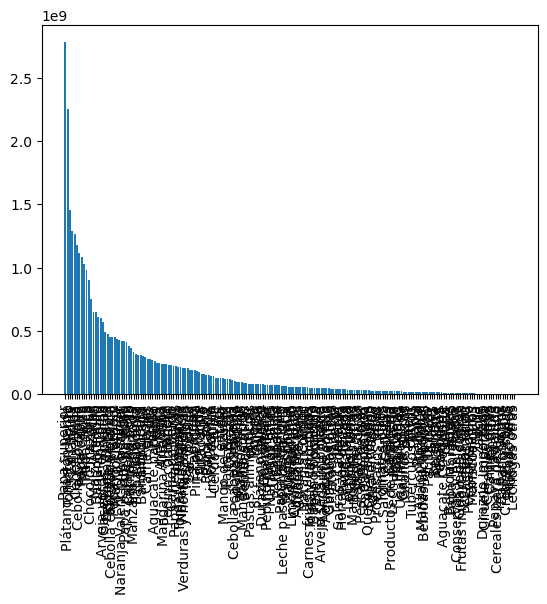

In [32]:
# Mostrar el mapa
st_folium(map, width=700, height=500)

# Crear gráfico de barras
st.header('Mayor Alimento Producido')
df_agg = df.groupby('Alimento')['Cant_Kg'].sum().reset_index().sort_values(by='Cant_Kg', ascending=False)
fig, ax = plt.subplots()
ax.bar(df_agg['Alimento'], df_agg['Cant_Kg'])
plt.xticks(rotation=90)
st.pyplot(fig)